# Self-play

In [1]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import clear_output

import argparse
import os
import random
import time
from distutils.util import strtobool

# import gym
from gridworld_ctf_mvp import GridworldCtf
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
# from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from IPython.display import clear_output

from collections import defaultdict



from agent_network import agent

import wandb

from ppo import PPOTrainer
from agent_network import Agent
from metrics_logger import MetricsLogger

### League Training

In [3]:
def duel(env, agent, opponent, max_steps=256, render=False, sleep_time=0.01):
    """
    Duelling algorithm.
    """

    step_count = 0
    done = False
    device = 'cpu'
    env.reset()

    while not done:
        step_count += 1

        actions = []
        
        for agent_idx in np.arange(env.N_AGENTS):
            # Get global and local states
            if env.AGENT_TEAMS[agent_idx]==0:
                grid_state = torch.tensor(env.standardise_state(agent_idx, use_ego_state=True), dtype=torch.float32).to(device)
                metadata_state = torch.tensor(env.get_env_metadata_local(agent_idx), dtype=torch.float32).to(device)
                action = agent.get_action(grid_state, metadata_state)
            else:
                grid_state = torch.tensor(env.standardise_state(agent_idx, use_ego_state=True, reverse_grid=True), dtype=torch.float32).to(device)
                metadata_state = torch.tensor(env.get_env_metadata_local(agent_idx), dtype=torch.float32).to(device)
                action = opponent.get_action(grid_state, metadata_state)
                action = env.get_reversed_action(action)

            actions.append(action)

        _, _, done = env.step(actions)

        if render:
            env.render(sleep_time=sleep_time)
            print(step_count, env.metrics['team_flag_captures'][0], env.metrics['team_flag_captures'][1])

        if step_count > max_steps:
            done = True

    return env.metrics['team_flag_captures'][0], env.metrics['team_flag_captures'][1]


In [5]:
class TrainingConfig():
    def __init__(self):
        #---------- Overall config
        self.wandb_project_name = "MARL-CTF-Test"
        self.exp_name = "Agent metrics logging"
        self.use_wandb_selfplay = True
        self.use_wandb_ppo = False
        self.seed = 42

        #---------- Self-play config
        self.number_of_iterations = 50
        self.number_of_duels = 3
        self.n_main_agents = 5
        self.n_exploiters = 3
        self.n_historical_agents = 20
        self.main_agent_update_interval = 5
        self.exploiter_update_interval = 2
        self.historical_update_interval = 2
        self.max_win_rate_diff = 1.0

        #---------- Environment config
        self.use_ego_state = True
        self.env_config = {
            'GRID_SIZE':8,
            'AGENT_CONFIG':{
                0: {'team':0, 'type':0},
                1: {'team':1, 'type':0},
                2: {'team':0, 'type':1},
                3: {'team':1, 'type':1},
            },
            'GAME_STEPS': 256,
            'USE_ADJUSTED_REWARDS': False,
            'RANDOMISE_FLAG_POSITIONS': False,
            'HOME_FLAG_CAPTURE': True,
            'ENABLE_OBSTACLES': False,
            'MAX_BLOCK_TILE_PCT': 0.05
        }

        #---------- PPO Config
        self.learning_rate = 0.0003
        self.total_timesteps = 10000
        self.torch_deterministic = True
        self.cuda = True
        self.wandb_entity = None
        self.capture_video = False
        self.parallel_rollouts = False
        self.num_envs = 4
        self.num_agents = 1
        self.num_steps = 256
        self.anneal_lr = False
        self.gae = True
        self.gamma = 0.95
        self.gae_lambda = 0.96
        self.num_minibatches = 4
        self.update_epochs = 4
        self.norm_adv = False
        self.clip_coef = 0.2
        self.clip_vloss = True
        self.ent_coef = 0.01
        self.vf_coef = 0.5
        self.max_grad_norm = 0.5
        self.target_kl = None
        self.batch_size = int(self.num_envs * self.num_steps * self.num_agents)
        self.minibatch_size = int(self.batch_size // self.num_minibatches)
        self.device = 'cpu'

        #---------- Metrics config

args = TrainingConfig()

In [6]:
def select_opponent(iteration, agent_idx, main_agents, exploiters, historical_agents, weights=(0.5, 0.3, 0.2)):
    """
    Select agents for training.
    """
    agent_types = ['main', 'exploiter', 'historical']
    
    # Adjust weights if we do not have any historical agents yet
    if len(historical_agents) == 0:
        weights = (weights[0]/sum(weights[:2]), weights[1]/sum(weights[:2]), 0.0)

    # Choose opponent
    opponent_type = np.random.choice(agent_types, p=weights)
    opponent_idx = np.random.choice(np.arange(len(main_agents)) if opponent_type == 'main' else
                            np.arange(len(exploiters)) if opponent_type == 'exploiter' else
                            np.arange(len(historical_agents)))
                            
    if opponent_type == 'main':
        opponent = main_agents[opponent_idx] 
    elif opponent_type == 'exploiter':
        opponent = exploiters[opponent_idx]
    else:
        opponent = historical_agents[opponent_idx]

    # Ensure agent1 and agent2 are different
    while main_agents[agent_idx] == opponent:
        opponent_type = np.random.choice(agent_types, p=weights)
        opponent_idx = np.random.choice(np.arange(len(main_agents)) if opponent_type == 'main' else
                                np.arange(len(exploiters)) if opponent_type == 'exploiter' else
                                np.arange(len(historical_agents)))
        if opponent_type == 'main':
            opponent = main_agents[opponent_idx] 
        elif opponent_type == 'exploiter':
            opponent = exploiters[opponent_idx]
        else:
            opponent = historical_agents[opponent_idx]

    print(f'Iteration: {iteration} Training main agent {agent_idx} vs {opponent_type} agent {opponent_idx}')
    return opponent

def select_agents(main_agents, exploiters, historical_agents, weights=(0.5, 0.3, 0.2)):
    """
    Select agents for training.
    """
    agent_types = ['main', 'exploiter', 'historical']
    
    # Adjust weights if we do not have any historical agents yet
    if len(historical_agents) == 0:
        weights = (weights[0]/sum(weights[:2]), weights[1]/sum(weights[:2]), 0.0)

    # Choose main agent
    agent_idx = rng.choice(len(main_agents))
    agent = main_agents[agent_idx]
    
    opponent_type = np.random.choice(agent_types, p=weights)
    opponent_idx = np.random.choice(np.arange(len(main_agents)) if opponent_type == 'main' else
                            np.arange(len(exploiters)) if opponent_type == 'exploiter' else
                            np.arange(len(historical_agents)))
                            
    if opponent_type == 'main':
        opponent = main_agents[opponent_idx] 
    elif opponent_type == 'exploiter':
        opponent = exploiters[opponent_idx]
    else:
        opponent = historical_agents[opponent_idx]

    # Ensure agent1 and agent2 are different
    while agent == opponent:
        opponent_type = np.random.choice(agent_types, p=weights)
        opponent_idx = np.random.choice(np.arange(len(main_agents)) if opponent_type == 'main' else
                                np.arange(len(exploiters)) if opponent_type == 'exploiter' else
                                np.arange(len(historical_agents)))
        if opponent_type == 'main':
            opponent = main_agents[opponent_idx] 
        elif opponent_type == 'exploiter':
            opponent = exploiters[opponent_idx]
        else:
            opponent = historical_agents[opponent_idx]

    print(f'Training main agent {agent_idx} vs {opponent_type} agent {opponent_idx}')
    return agent, opponent

def update_main_agents(main_agents, win_rate_dict, max_win_rate_diff=args.max_win_rate_diff):
    """
    Update agents based on relative performance.
    """
    # Get the probability of adding each main agent, based on their win rates
    win_rates = np.array([v for v in win_rate_dict.values()])
    probs = win_rates/ sum(win_rates)

    if max(win_rates) - min(win_rates) > max_win_rate_diff:
        # Get the main agent to add
        agent_to_add = np.argmax(probs)
        agent_to_remove = np.argmin(probs)

        print(f'Copying agent {agent_to_add}, removing agent {agent_to_remove}')

        # Add the main agent to the historical agents pool
        new_agent = main_agents[agent_to_add]
        main_agents.append(new_agent)

        # Maintain the pool size
        del main_agents[agent_to_remove]

def update_exploiters(main_agents, exploiters):
    """
    Train exploiters against main agents.
    """
    for exploiter_idx, exploiter in enumerate(exploiters):
        print(f'Updating exploiter {exploiter_idx}')
        main_agent = random.choice(main_agents)  # Select a main agent to target

        ppotrainer.train_ppo(args, env, exploiter, main_agent)
        clear_output()

def update_historical_agents(main_agents, historical_agents, win_rate_dict, max_pool_size=args.n_historical_agents):
    """
    Add main agents to history.
    """
    # Get the probability of adding each main agent, based on their win rates
    win_rates = np.array([v for v in win_rate_dict.values()])
    probs = win_rates / sum(win_rates)

    # Get the main agent to add
    main_agent_to_add = random.choices(main_agents, probs, k=1)[0]

    # Add the main agent to the historical agents pool
    historical_agents.append(main_agent_to_add)

    # Maintain the pool size
    if len(historical_agents) > max_pool_size:
        historical_agents.pop(0)  # Remove the oldest agent

In [7]:
rng = np.random.default_rng(args.seed)

# Initialise environment
env = GridworldCtf(**args.env_config)

dims_data = env.get_env_dims()
local_grid_dims = dims_data[0]
global_grid_dims = dims_data[1]
local_metadata_dims = dims_data[2]
global_metadata_dims = dims_data[3]
n_channels = local_grid_dims[0]

#----------------------------------------------------------------------
# Initialise agent population
#----------------------------------------------------------------------
main_agents = []
exploiters = []
historical_agents = []

for _ in range(args.n_main_agents):
    main_agents.append(Agent(n_channels, env.GRID_SIZE, local_metadata_dims[0]).to(args.device))

for _ in range(args.n_exploiters):
    exploiters.append(Agent(n_channels, env.GRID_SIZE, local_metadata_dims[0]).to(args.device))

# Setup PPO trainer
ppotrainer = PPOTrainer(args, local_grid_dims, local_metadata_dims)

if args.use_wandb_selfplay:
    wandb.init(project=args.wandb_project_name,
                name=args.exp_name,
                config=vars(args))

# Setup metrics logger
metlog = MetricsLogger(args.n_main_agents)
                
#----------------------------------------------------------------------
# League Training Start
#----------------------------------------------------------------------
for iteration in range(args.number_of_iterations):

    for agent_idx, agent in enumerate(main_agents):
        #TODO: Update to select multiple opponents and return as a list
        # Select agent to train and opponent
        opponent = select_opponent(iteration, agent_idx, main_agents, exploiters, historical_agents)

        #TODO: Update train_ppo method to accept a list of opponents
        # Train PPO
        ppotrainer.train_ppo(args, env, agent, opponent)
        clear_output()

    #----------------------------------------------------------------------
    # Duelling Phase and harvest of metrics
    #----------------------------------------------------------------------
    print(f'Iteration: {iteration} Duelling...')
    all_agents = main_agents + exploiters + historical_agents
    win_rate_dict = {i:0 for i in range(len(main_agents))}
    for agent_idx, agent in enumerate(main_agents):
        for opponent_idx, opponent in enumerate(all_agents):
            if agent_idx != opponent_idx:
                # print(f'agent {agent_idx} vs opponent {opponent_idx}')
                for _ in range(args.number_of_duels):
                    scaling_factor = 1 / (len(all_agents) - 1 + args.number_of_duels)
                    agent_score, opponent_score = duel(env, agent, opponent)
                    if agent_score > opponent_score:
                        win_rate_dict[agent_idx] += 1 / (args.number_of_duels * len(all_agents)-1)

                    # Log metrics -> track for main agents
                    metlog.harvest_metrics(env, agent_idx, iteration, scaling_factor)

    print(f'Win rates:\n{win_rate_dict}')

    # Log metrics
    if args.use_wandb_selfplay:
        metlog.log_to_wandb()

    #----------------------------------------------------------------------
    # Update agent pools
    #----------------------------------------------------------------------
    if iteration % args.main_agent_update_interval == 0:
        print(f'Iteration: {iteration} Updating main agents')
        update_main_agents(main_agents, win_rate_dict, max_win_rate_diff=args.max_win_rate_diff)

    if iteration % args.exploiter_update_interval == 0:
        print(f'Iteration: {iteration} Updating exploiters')
        update_exploiters(main_agents, exploiters)

    if iteration % args.historical_update_interval == 0:
        print(f'Iteration: {iteration} Updating historical agent pool')
        update_historical_agents(main_agents, historical_agents, win_rate_dict, max_pool_size=args.n_historical_agents)

# Close wandb session
if args.use_wandb_selfplay:
    metlog.log_matplotlib_plots_to_wandb()
    # metlog.log_wandb_table_plots()
    wandb.finish()

Iteration: 49 Duelling...
Win rates:
{0: 0.20481927710843378, 1: 0.28915662650602414, 2: 0.5542168674698794, 3: 0.40963855421686735, 4: 0.3253012048192771}


/Users/geoffrey.nightingale@contino.io/opt/anaconda3/envs/torch-env/lib/python3.9/site-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/Users/geoffrey.nightingale@contino.io/opt/anaconda3/envs/torch-env/lib/python3.9/site-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/Users/geoffrey.nightingale@contino.io/opt/anaconda3/envs/torch-env/lib/python3.9/site-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/Users/geoffrey.nightingale@contino.io/opt/anaconda3/envs/torch-env/lib/python3.9/site-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/Users/geoffrey.nightingale@contino.io/opt/anaconda3/envs/torch-env/lib/python3.9/site-packages/plotly/matpl

"agent_type_blocks_laid (agent:0, agent type:0)",▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
"agent_type_blocks_laid (agent:0, agent type:1)",▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
"agent_type_blocks_laid (agent:1, agent type:0)",▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
"agent_type_blocks_laid (agent:1, agent type:1)",▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
"agent_type_blocks_laid (agent:2, agent type:0)",▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
"agent_type_blocks_laid (agent:2, agent type:1)",▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
"agent_type_blocks_laid (agent:3, agent type:0)",▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
"agent_type_blocks_laid (agent:3, agent type:1)",▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
"agent_type_blocks_laid (agent:4, agent type:0)",▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
"agent_type_blocks_laid (agent:4, agent type:1)",▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
"agent_type_blocks_mined (agent:0, agent type:0)",▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


### Testing Trained Policies

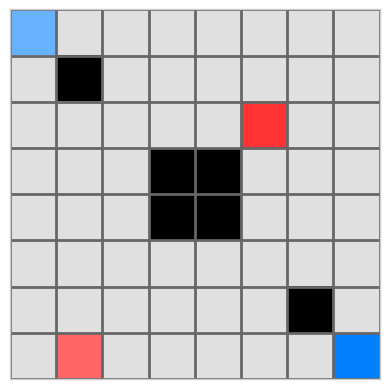

256 2 0


(2, 0)

In [10]:
agent = main_agents[0]
opponent = main_agents[2]
duel(env, agent, opponent, render=True, sleep_time=0.2)

In [13]:
env.get_env_metadata_local(0)

array([[1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.]],
      dtype=float16)

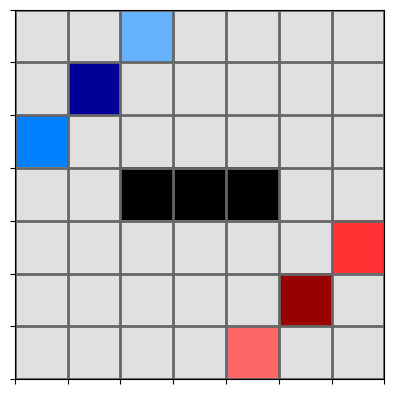

Move 0
Game exited


In [41]:
env.reset()
env.play()

In [49]:
print(env.metrics['team_flag_captures'])
print(env.metrics['agent_type_flag_captures'][0])
print(env.metrics['agent_flag_captures'])

{0: 7, 1: 2}
defaultdict(<class 'int'>, {1: 1, 0: 6})
defaultdict(<class 'int'>, {3: 2, 2: 1, 0: 6})
